# Portuguese Text Classifier on TCU jurisprudência dataset
- ### Architecture 4 QRNN with 1550 hidden parameters by layer, SentencePiece tokenizer (15 000 tokens)
- ### Hyperparameters and training method from the MultiFiT paper

- Author: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou)
- Date: September 2019
- Post in medium: link
- Ref: [Fastai v1](https://docs.fast.ai/) (Deep Learning library on PyTorch)

**Information**

According to this new article "[MultiFiT: Efficient Multi-lingual Language Model Fine-tuning](https://arxiv.org/abs/1909.04761)" (September 10, 2019), the QRNN architecture and the SentencePiece tokenizer give better results than AWD-LSTM and the spaCy tokenizer respectively. 

Therefore, they have been used in this notebook to **fine-tune a Portuguese Bidirectional Language Model** by Transfer Learning of a Portuguese Bidirectional Language Model (with the QRNN architecture and the SentencePiece tokenizer, too) trained on a Wikipedia corpus of 100 millions tokens ([lm3-portuguese.ipynb](https://github.com/piegu/language-models/blob/master/lm3-portuguese.ipynb)). 

This Portuguese Bidirectional Language Model has been **fine-tuned on the [tcu_jurisp_reduzido.csv dataset about TCU jurisprudência](https://github.com/fastai-bsb/nlp-tcu-enunciados/blob/master/tcu_jurisp_reduzido.csv?raw=true)"** and **its encoder part has been transfered to a text classifier which has been finally trained on this corpus**.

This process **LM General --> LM fine-tuned --> Classifier fine-tuned** is called [ULMFiT](http://nlp.fast.ai/category/classification.html) but we trained our 3 models with the hyperparameters values and method of the [MultiFiT](https://arxiv.org/abs/1909.04761) paper that are given at the end of the MultiFiT paper.

**Hyperparameters values**

- Language Model
    - (batch size) bs = 50
    - (QRNN) 4 QRNN (default: 3) with 1550 hidden parameters each one (default: 1152)
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 1.0
    - (weight decay) wd = 0.1
    - (number of training epochs) 20 epochs
    - (learning rate) modified version of 1-cycle learning rate schedule (Smith, 2018) that uses cosine instead of linear annealing, cyclical momentum and discriminative finetuning
    - (loss) FlattenedLoss of weighted LabelSmoothingCrossEntropy
    

- Sentiment Classifier
    - (batch size) bs = 18
    - (SentencePiece) vocab of 15000 tokens
    - (dropout) mult_drop = 0.3
    - (weight decay) wd = 0.1
    - (number of training epochs) 14 epochs (forward) and 19 epochs (backward)
    - (learning rate) modified version of 1-cycle learning rate schedule (Smith, 2018) that uses cosine instead of linear annealing, cyclical momentum and discriminative finetuning
    - (loss) FlattenedLoss of weighted LabelSmoothingCrossEntropy 

## Results

**We can conclude that this Bidirectional Portuguese LM model using the MultiFiT configuration is a good model to perform text classification but with about 42 millions of parameters, it is far from being a LM that can gan compete with [GPT-2](https://openai.com/blog/better-language-models/) or [BERT](https://arxiv.org/abs/1810.04805) in NLP tasks like text generation.**

- **About the data**: the dataset [tcu_jurisp_reduzido.csv](https://github.com/fastai-bsb/nlp-tcu-enunciados/blob/master/tcu_jurisp_reduzido.csv?raw=true) about "TCU jurisprudência" is unbalanced. Therefore, we used a weighted loss function (FlattenedLoss of weighted LabelSmoothingCrossEntropy).
    - number of texts: 10263
        - class 0: 3468 (33.79%)
        - class 1: 2723 (26.53%)
        - class 2: 2297 (22.38%)
        - class 3: 1775 (17.3%)


- **(fine-tuned) Language Model**   
    - forward : (accuracy) 44.66% | (perplexity) 15.97
    - backward: (accuracy) 44.97% | (perplexity) 18.73
    

- **(fine-tuned) Text Classifier**

    - **Accuracy**
        - forward : (global) 96.88% | **(class 0) 98.80%** | (class 1) 98.59% | (class 2) 95.31% | **(class 3) 95.89%**
        - backward: (global) 96.69% | (class 0) 97.58% | (class 1) 98.59% | (class 2) 93.90% | (class 3) 95.43%
        - ensemble: (global) **97.39%** | (class 0) 98.19% | **(class 1) 98.94%** | **(class 2) 96.71%** | (class 3) 94.42%

    - **f1 score**
        - forward: 0.9687
        - backward: 0.9669
        - ensemble: **0.9737**

(neg = negative reviews | pos = positive reviews)

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [2]:
!python -m fastai.utils.show_install



```text
=== Software === 
python        : 3.7.4
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16130MB | Tesla V100-SXM2-16GB

=== Environment === 
platform      : Linux-4.9.0-9-amd64-x86_64-with-debian-9.9
distro        : #1 SMP Debian 4.9.168-1+deb9u5 (2019-08-11)
conda env     : base
python        : /opt/anaconda3/bin/python
sys.path      : /home/jupyter/tutorials/fastai/course-nlp
/opt/anaconda3/lib/python37.zip
/opt/anaconda3/lib/python3.7
/opt/anaconda3/lib/python3.7/lib-dynload
/opt/anaconda3/lib/python3.7/site-packages
/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:


In [3]:
# bs=48
# bs=24
bs=50

In [4]:
torch.cuda.set_device(0)

In [5]:
data_path = Config.data_path()

This will create a `{lang}wiki` folder, containing a `{lang}wiki` text file with the wikipedia contents. (For other languages, replace `{lang}` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [6]:
lang = 'pt'

In [7]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

lm_fns3 = [f'{lang}_wt_sp15_multifit', f'{lang}_wt_vocab_sp15_multifit']
lm_fns3_bwd = [f'{lang}_wt_sp15_multifit_bwd', f'{lang}_wt_vocab_sp15_multifit_bwd']

## Data

TCU jurisprudência:
- reduzido: https://github.com/fastai-bsb/nlp-tcu-enunciados/blob/master/tcu_jurisp_reduzido.csv
- completo: https://github.com/fastai-bsb/nlp-tcu-enunciados/blob/master/tcu_jurisp.csv

### Download

In [8]:
import urllib.request
from converter import *

In [9]:
# create TCU folder
name_data = 'TCU'
path_data = data_path/name_data
path_data.mkdir(exist_ok=True, parents=True)

In [10]:
%%time
# Download each file from url and save it locally under file_name

url = 'https://github.com/fastai-bsb/nlp-tcu-enunciados/blob/master/tcu_jurisp_reduzido.csv?raw=true'
file_name = 'tcu_jurisp_reduzido.csv'
url_file = path_data/file_name
urllib.request.urlretrieve(url, url_file)

url = 'https://raw.githubusercontent.com/fastai-bsb/nlp-tcu-enunciados/master/tcu_jurisp.csv'
file_name = 'tcu_jurisp.csv'
url_file = path_data/file_name
urllib.request.urlretrieve(url, url_file)

CPU times: user 48 ms, sys: 20 ms, total: 68 ms
Wall time: 1.41 s


(PosixPath('/home/jupyter/.fastai/data/TCU/tcu_jurisp.csv'),
 <http.client.HTTPMessage at 0x7f9a1cec6b50>)

In [11]:
path_data.ls()

[PosixPath('/home/jupyter/.fastai/data/TCU/tcu_jurisp_reduzido_preprocessed.csv'),
 PosixPath('/home/jupyter/.fastai/data/TCU/tcu_jurisp_reduzido.csv'),
 PosixPath('/home/jupyter/.fastai/data/TCU/tcu_jurisp.csv')]

In [12]:
!head -n4 {path_data.ls()[0]}

text,labels
"A medida cautelar do TCU que determina a suspensão de licitação por falhas no edital não impede o órgão ou a entidade de rever seu ato convocatório, valendo-se do poder de autotutela (art. 49 da Lei 8.666/1993 c/c o art. 9º da Lei 10.520/2002) , com o objetivo de, antecipando-se a eventual deliberação do Tribunal, promover de modo próprio a anulação da licitação e o refazimento do edital, livre dos vícios apontados.",3
"A retenção de recursos pela Administração com vistas ao ressarcimento do prejuízo ou a existência de ação judicial para o reconhecimento do dano ao erário não constituem óbices ao prosseguimento da tomada de contas especial no TCU. Ocorrendo ressarcimento em uma instância, basta que o responsável apresente essa comprovação perante o juízo de execução para evitar o duplo pagamento.</p><p><b>Enunciado </b>",3
"Para fins de admissibilidade de recurso de revisão, considera-se documento novo todo aquele ainda não examinado no processo.",3


### Overview

In [13]:
# to solve display error of pandas dataframe
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [14]:
df = pd.read_csv(path_data/'tcu_jurisp_reduzido.csv', encoding='utf-8')
print(len(df))
print(Counter(df.labels))
df.head()

10263
Counter({0: 3468, 1: 2723, 2: 2297, 3: 1775})


,Unnamed: 0,labels,text
0,0,3,A medida cautelar do TCU que determina a suspe...
1,1,3,A retenção de recursos pela Administração com ...
2,2,3,Para fins de admissibilidade de recurso de rev...
3,3,3,"Fotografias não têm pleno valor probatório, so..."
4,4,3,Não cabe instauração de tomada de contas espec...


In [15]:
df = pd.read_csv(path_data/'tcu_jurisp.csv', encoding='utf-8')
print(len(df))
print(Counter(df.labels))
df.head()

13258
Counter({0: 3468, 1: 2723, 2: 2297, 3: 1775, 4: 932, 5: 673, 6: 572, 7: 343, 8: 337, 9: 138})


,Unnamed: 0,labels,text
0,0,6,O TCU tem competência para fiscalizar a aplica...
1,1,6,"Não compete ao TCU apreciar, para fins de regi..."
2,2,6,Compete ao TCU a apreciação da constitucionali...
3,3,6,É possível a expedição de determinação pelo TC...
4,4,6,"O TCU não tem competência, no âmbito do Progra..."


### Analysis (reduzido file)

In [16]:
df = pd.read_csv(path_data/'tcu_jurisp_reduzido.csv', encoding='utf-8')
print(len(df))
print(Counter(df.labels))
df.head()

10263
Counter({0: 3468, 1: 2723, 2: 2297, 3: 1775})


,Unnamed: 0,labels,text
0,0,3,A medida cautelar do TCU que determina a suspe...
1,1,3,A retenção de recursos pela Administração com ...
2,2,3,Para fins de admissibilidade de recurso de rev...
3,3,3,"Fotografias não têm pleno valor probatório, so..."
4,4,3,Não cabe instauração de tomada de contas espec...


In [17]:
# columns names
reviews = "text"
label = "labels"

# keep columns
df2 = df[[reviews,label]].copy()

In [18]:
# number of reviews
print(f'(orginal csv) number of all reviews: {len(df2)}')

# keep not null reviews
## delete nan reviews
empty_nan = (df2[reviews].isnull()).sum()
df2 = df2[df2[reviews].notnull()]
## delete empty reviews
list_idx_none = []
for idxs, row in df2.iterrows():
    if row[reviews].strip() == "":
        df2.drop(idxs, axis=0, inplace=True)
        list_idx_none.append(idxs)
empty_none = len(list_idx_none)
## print results
empty = empty_nan+empty_none
if empty != 0:
    print(f'{empty} empty reviews were deleted')
else:
    print('there is no empty review.')

# # check that there is no twice the same review
# # keep the first of unique review_id reviews
# same = len(df2) - len(df2[idx].unique())
# if same != 0:
#     df2.drop_duplicates(subset=[idx], inplace=True)
#     print(f'from the {same} identical reviews ids, only the first one has been kept.')
# else:
#     print('there is no identical review id.')

## delete nan labels
empty_label_nan = (df2[label].isnull()).sum()
df2 = df2[df2[label].notnull()]
print(f'{empty_label_nan} reviews with nan label were deleted')

# number of reviews by class
counter = Counter(df2[label])
clas_0, clas_1, clas_2, clas_3 = counter[0], counter[1], counter[2], counter[3]
num = len(df2)
pc_clas_0, pc_clas_1 = round((clas_0/num)*100,2), round((clas_1/num)*100,2)
pc_clas_2, pc_clas_3 = round((clas_2/num)*100,2), round((clas_3/num)*100,2)
print(f'\nnumber of text of class 0: {clas_0} ({pc_clas_0}%)')
print(f'number of text of class 1: {clas_1} ({pc_clas_1}%)')
print(f'number of text of class 2: {clas_2} ({pc_clas_2}%)')
print(f'number of text of class 3: {clas_3} ({pc_clas_3}%)')
print(f'\n(final) number of all texts: {num}')  

# convert HTML caracters to normal letters
df2[reviews] = df2[reviews].apply(convert)

df2.head(5)

(orginal csv) number of all reviews: 10263
there is no empty review.
0 reviews with nan label were deleted

number of text of class 0: 3468 (33.79%)
number of text of class 1: 2723 (26.53%)
number of text of class 2: 2297 (22.38%)
number of text of class 3: 1775 (17.3%)

(final) number of all texts: 10263


,text,labels
0,A medida cautelar do TCU que determina a suspe...,3
1,A retenção de recursos pela Administração com ...,3
2,Para fins de admissibilidade de recurso de rev...,3
3,"Fotografias não têm pleno valor probatório, so...",3
4,Não cabe instauração de tomada de contas espec...,3



number of text of class 0: 3468 (33.79%)
number of text of class 1: 2723 (26.53%)
number of text of class 2: 2297 (22.38%)
number of text of class 3: 1775 (17.3%)

(final) number of all texts: 10263


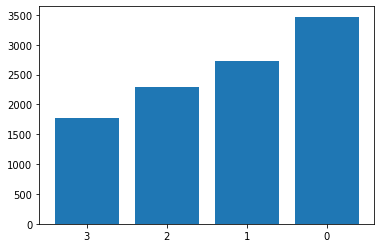

In [19]:
df_trn_val = df2.copy()

# number of reviews by class
counter = Counter(df_trn_val[label])
clas_0, clas_1, clas_2, clas_3 = counter[0], counter[1], counter[2], counter[3]
num = len(df_trn_val)
pc_clas_0, pc_clas_1 = round((clas_0/num)*100,2), round((clas_1/num)*100,2)
pc_clas_2, pc_clas_3 = round((clas_2/num)*100,2), round((clas_3/num)*100,2)
print(f'\nnumber of text of class 0: {clas_0} ({pc_clas_0}%)')
print(f'number of text of class 1: {clas_1} ({pc_clas_1}%)')
print(f'number of text of class 2: {clas_2} ({pc_clas_2}%)')
print(f'number of text of class 3: {clas_3} ({pc_clas_3}%)')
print(f'\n(final) number of all texts: {num}') 

# plot histogram
keys = list(df_trn_val[label].value_counts().keys())
values = list(df_trn_val[label].value_counts().array)
plt.bar(keys, values[::-1]) 
plt.xticks(keys, keys[::-1])
# print(df_trn_val['label'].value_counts())
plt.show()

In [20]:
df_trn_val.head()

,text,labels
0,A medida cautelar do TCU que determina a suspe...,3
1,A retenção de recursos pela Administração com ...,3
2,Para fins de admissibilidade de recurso de rev...,3
3,"Fotografias não têm pleno valor probatório, so...",3
4,Não cabe instauração de tomada de contas espec...,3


In [21]:
df_trn_val.to_csv (path_data/'tcu_jurisp_reduzido_preprocessed.csv', index = None, header=True)

## Fine-tuning "forward LM"

### Databunch

In [31]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols=reviews, 
                            processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

CPU times: user 5.25 s, sys: 540 ms, total: 5.79 s
Wall time: 4.43 s


In [32]:
data_lm.save(f'{path}/{lang}_databunch_lm_tcu_jurisp_reduzido_sp15_multifit')

### Training

In [316]:
data_lm = load_data(path, f'{lang}_databunch_lm_tcu_jurisp_reduzido_sp15_multifit', bs=bs)

In [317]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [318]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 688 ms, sys: 100 ms, total: 788 ms
Wall time: 423 ms


In [324]:
# number of model parameters
sum([p.numel() for p in learn_lm.model.parameters()])

42116014

In [320]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5264, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5264, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=800, out_features=4650, bias=True)
            )
          )
        )
      )
      (1): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=1550, out_features=4650, bias=True)
            )
          )
        )
      )
      (2): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=1550, out_features=4650, bias=True)
            )
          )
        )
      )
      (3): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDro

#### Change loss function

In [93]:
learn_lm.loss_func

FlattenedLoss of CrossEntropyLoss()

In [94]:
learn_lm.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

In [95]:
learn_lm.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

#### Training

In [96]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


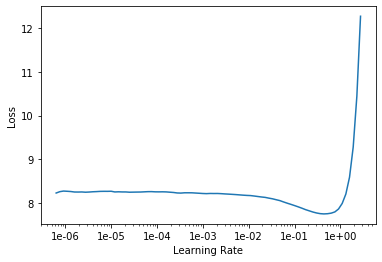

In [97]:
learn_lm.recorder.plot()

In [98]:
lr = 2e-2
lr *= bs/48

wd = 0.1

In [99]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,23.082850,13.639015,0.959905,0.040095,441221.843750,00:05
1,9.152627,6.902425,0.942333,0.057667,667.627136,00:05


In [100]:
learn_lm.save(f'{lang}fine_tuned1_tcu_jurisp_reduzido_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_tcu_jurisp_reduzido_sp15_multifit')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,6.553828,6.341281,0.895270,0.104730,387.510712,00:07
1,5.899654,5.492898,0.804079,0.195921,145.609436,00:07
2,5.221296,4.888595,0.742159,0.257841,71.675606,00:07
3,4.806045,4.559645,0.704397,0.295603,47.392849,00:07
4,4.582712,4.381135,0.683460,0.316540,38.152508,00:07
5,4.428261,4.271377,0.668524,0.331476,33.936054,00:07
6,4.324153,4.175958,0.655127,0.344873,29.984440,00:07
7,4.229700,4.108614,0.645968,0.354032,27.735703,00:07
8,4.140501,4.051945,0.636270,0.363730,26.340155,00:07
9,4.035665,3.970170,0.621857,0.378143,23.693985,00:07


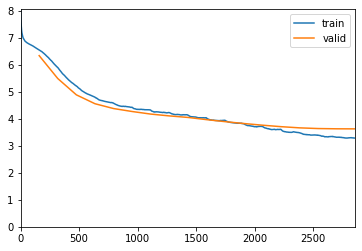

In [101]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(18, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [102]:
learn_lm.save(f'{lang}fine_tuned2_lenerbr_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_lenerbr_sp15_multifit')

Save best LM learner and its encoder

In [103]:
learn_lm.save(f'{lang}fine_tuned_tcu_jurisp_reduzido_sp15_multifit')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_tcu_jurisp_reduzido_sp15_multifit')

## Fine-tuning "backward LM"

### Databunch

In [104]:
%%time
data_lm = (TextList.from_df(df_trn_val, path, cols=reviews, 
                            processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 5.09 s, sys: 456 ms, total: 5.54 s
Wall time: 4.13 s


In [105]:
data_lm.save(f'{path}/{lang}_databunch_lm_tcu_jurisp_reduzido_sp15_multifit_bwd')

### Training

In [106]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_tcu_jurisp_reduzido_sp15_multifit_bwd', bs=bs, backwards=True)

CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 85.1 ms


In [107]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [108]:
%%time
perplexity = Perplexity()
learn_lm = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained_fnames=lm_fns3_bwd, drop_mult=1., 
                                  metrics=[error_rate, accuracy, perplexity]).to_fp16()

CPU times: user 744 ms, sys: 124 ms, total: 868 ms
Wall time: 1.58 s


#### Change loss function

In [109]:
learn_lm.loss_func

FlattenedLoss of CrossEntropyLoss()

In [110]:
learn_lm.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)

In [111]:
learn_lm.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

#### Training

In [112]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


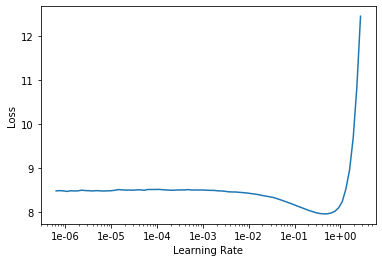

In [113]:
learn_lm.recorder.plot()

In [114]:
lr = 2e-2
lr *= bs/48

wd = 0.1

In [115]:
learn_lm.fit_one_cycle(2, lr*10, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,27.910931,14.435742,0.969365,0.030635,1081162.125000,00:05
1,11.221999,7.274082,0.953698,0.046302,977.145325,00:05


In [116]:
learn_lm.save(f'{lang}fine_tuned1_tcu_jurisp_reduzido_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned1_enc_tcu_jurisp_reduzido_sp15_multifit_bwd')

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,6.796478,6.747334,0.936095,0.063905,623.787720,00:07
1,6.464913,6.255675,0.861175,0.138825,343.101746,00:07
2,5.795866,5.434357,0.762698,0.237302,132.005173,00:07
3,5.144683,4.851414,0.697286,0.302714,67.983307,00:07
4,4.803105,4.600672,0.672857,0.327143,50.131386,00:07
5,4.618645,4.451552,0.657587,0.342413,41.944103,00:07
6,4.482847,4.339243,0.644794,0.355206,36.868359,00:07
7,4.391364,4.255972,0.635270,0.364730,33.452030,00:07
8,4.280099,4.178698,0.622936,0.377063,30.320036,00:07
9,4.192408,4.103323,0.615349,0.384651,28.363132,00:07


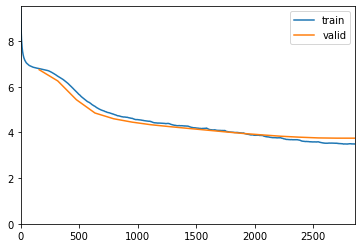

In [117]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(18, lr, wd=wd, moms=(0.8,0.7), callbacks=[ShowGraph(learn_lm)])

In [118]:
learn_lm.save(f'{lang}fine_tuned2_tcu_jurisp_reduzido_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned2_enc_tcu_jurisp_reduzido_sp15_multifit_bwd')

Save best LM learner and its encoder

In [119]:
learn_lm.save(f'{lang}fine_tuned_tcu_jurisp_reduzido_sp15_multifit_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_tcu_jurisp_reduzido_sp15_multifit_bwd')

## Fine-tuning "forward Classifier"

In [120]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on

In [121]:
bs = 18

### Databunch

In [122]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_tcu_jurisp_reduzido_sp15_multifit', bs=bs)

CPU times: user 76 ms, sys: 4 ms, total: 80 ms
Wall time: 78.6 ms


In [123]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols=reviews, 
                              processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=label)
    .databunch(bs=bs, num_workers=1))

CPU times: user 5.32 s, sys: 444 ms, total: 5.77 s
Wall time: 4.46 s


In [124]:
%%time
data_clas.save(f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit')

CPU times: user 160 ms, sys: 12 ms, total: 172 ms
Wall time: 175 ms


### Get weights to penalize loss function of the majority class

In [125]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit', bs=bs, num_workers=1)

CPU times: user 340 ms, sys: 20 ms, total: 360 ms
Wall time: 340 ms


In [126]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(9237, 1026, 10263)

In [127]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([3136, 2439, 2084, 1578]), array([332, 284, 213, 197]))

In [128]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.6604958319800801,
  0.7359532315686912,
  0.7743856230377828,
  0.8291653134134459],
 [0.6764132553606238,
  0.723196881091618,
  0.7923976608187134,
  0.8079922027290448])

### Training (Loss = FlattenedLoss of weighted LabelSmoothingCrossEntropy)

In [129]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit', bs=bs, num_workers=1)

CPU times: user 344 ms, sys: 36 ms, total: 380 ms
Wall time: 353 ms


In [130]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [131]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='weighted')

In [132]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=0.3, 
                                  metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_tcu_jurisp_reduzido_sp15_multifit');

#### Change loss function

In [133]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [134]:
# source: https://github.com/fastai/fastai/blob/master//fastai/layers.py#L300:7
# blog: https://bfarzin.github.io/Label-Smoothing/
class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [135]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

In [136]:
learn_c.loss_func

FlattenedLoss of WeightedLabelSmoothingCrossEntropy()

#### Training

In [137]:
learn_c.freeze()

In [138]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


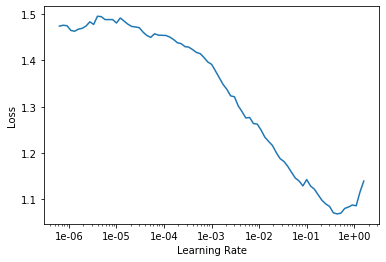

In [139]:
learn_c.recorder.plot()

In [140]:
lr = 2e-1
lr *= bs/48

wd = 0.1

In [141]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.736745,0.713937,0.832359,0.818395,00:05
1,0.668577,0.577937,0.887914,0.888967,00:05


In [142]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')

In [143]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.711872,0.846949,0.728070,0.695590,00:05
1,0.619364,0.576281,0.882066,0.883549,00:05


In [144]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')

In [145]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.671086,422.958496,0.323587,0.174381,00:06
1,0.530306,0.457585,0.956140,0.954496,00:06


In [146]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')

In [147]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.593900,0.568828,0.910331,0.907177,00:08
1,0.500131,0.447539,0.954191,0.953421,00:07


In [148]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')

In [149]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.493010,0.458026,0.952242,0.951032,00:13
1,0.456148,0.427546,0.966862,0.966696,00:12


In [150]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')

In [153]:
learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')
learn_c.fit_one_cycle(2, slice(lr/100/(2.6**4),lr/100), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.434293,0.429002,0.965887,0.965594,00:12
1,0.427529,0.430999,0.967836,0.967533,00:12


In [154]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')

In [156]:
learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')
learn_c.fit_one_cycle(2, slice(lr/1000/(2.6**4),lr/1000), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.424318,0.427883,0.968811,0.968508,00:13
1,0.422475,0.427418,0.968811,0.968782,00:13


In [157]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit')

### Confusion matrix

In [158]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit', bs=bs, num_workers=1)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, pretrained=False, drop_mult=1.0, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_tcu_jurisp_reduzido_sp15_multifit');

learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

CPU times: user 668 ms, sys: 104 ms, total: 772 ms
Wall time: 769 ms


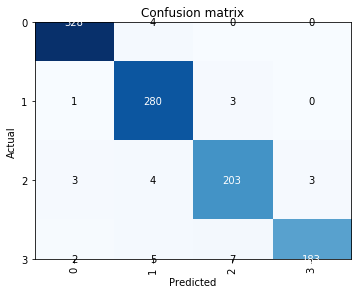

In [159]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [160]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3])/(cm.sum())}')

# acc neg, acc pos
print(f'accuracy on class 0: {cm[0,0]/(cm.sum(1)[0])*100}') 
print(f'accuracy on class 1: {cm[1,1]/(cm.sum(1)[1])*100}')
print(f'accuracy on class 2: {cm[2,2]/(cm.sum(1)[2])*100}')
print(f'accuracy on class 3: {cm[3,3]/(cm.sum(1)[3])*100}')

[[328   4   0   0]
 [  1 280   3   0]
 [  3   4 203   3]
 [  2   5   7 183]]
accuracy global: 0.9688109161793372
accuracy on class 0: 98.79518072289156
accuracy on class 1: 98.59154929577466
accuracy on class 2: 95.30516431924883
accuracy on class 3: 92.89340101522842


In [161]:
learn_c.show_results()

text,target,prediction
"▁xxbos ▁a ▁assistência ▁judicial ▁por ▁parte ▁do ▁xxmaj ▁poder ▁xxmaj ▁público ▁aos ▁membros ▁do ▁xxmaj ▁ministério ▁xxmaj ▁público ▁da ▁xxmaj ▁união , ▁em ▁ações ▁propostas ▁por ▁pessoas ▁físicas ▁ou ▁jurídicas ▁por ▁eles ▁investiga das , ▁deve rá ▁pautar - se ▁pelos ▁seguinte s ▁critérios : < ▁/ ▁p >< p > a ) ▁nas ▁hipóteses ▁em ▁que ▁as ▁demanda s ▁judiciais ▁movida s ▁contra ▁os ▁membros ▁do ▁xxmaj ▁ministério ▁xxmaj",1,1
"▁xxbos ▁xxmaj ▁nos ▁processos ▁licitatórios ▁sob ▁a ▁modalidade ▁pregão ▁que ▁se ▁de s ti n em ▁ao ▁fornecimento ▁de ▁bens ▁e ▁serviços ▁comuns ▁de ▁informática ▁e ▁automação , ▁verificado ▁em pa te ▁entre ▁propostas ▁comerciais , ▁a ▁xxmaj ▁administração ▁xxmaj ▁pública ▁xxmaj ▁federal ▁deve rá ▁adotar ▁os ▁seguinte s ▁procedimentos : ▁i . ▁analisa r , ▁primeiro , ▁se ▁algum ▁dos ▁licitantes ▁está ▁oferta ndo ▁bem ▁ou ▁serviço ▁que ▁preencha",1,1
"▁xxbos ▁xxmaj ▁os ▁requisitos ▁a ▁ser em ▁preenchidos , ▁no ▁momento ▁do ▁óbito ▁do ▁instituidor , ▁para ▁a ▁habilitação ▁e ▁manutenção ▁da ▁qualidade ▁de ▁filha ▁maior ▁solteira , ▁como ▁dependente ▁de ▁pensão ▁são : ▁a ) ▁ser ▁solteira , ▁viúva ▁ou ▁desquitada , ▁independente mente ▁da ▁idade ▁( po de ▁ser ▁maior ▁ou ▁menor ▁de ▁21 ▁anos ) ▁ ; ▁b ) ▁não ▁ser ▁ocupante ▁de ▁cargo ▁público ▁permanente ▁na",0,0
"▁xxbos ▁é ▁permitida ▁a ▁utilização ▁do ▁chamamento ▁público ▁para ▁permuta ▁de ▁imóveis ▁da ▁xxmaj ▁união ▁como ▁mecanismo ▁de ▁pro s p ec ção ▁de ▁mercado , ▁para ▁fim ▁de ▁identificar ▁os ▁imóveis ▁ele g íveis ▁que ▁atenda m ▁às ▁necessidade s ▁da ▁xxmaj ▁união , ▁com ▁atendimento ▁aos ▁princípios ▁da ▁impessoalidade , ▁moralidade ▁e ▁publicidade , ▁devendo , ▁posteriormente , ▁ser ▁utilizadas ▁vári as ▁fontes ▁de ▁pesquisa ▁para ▁certificação ▁de",1,1
"▁xxbos ▁é ▁legal ▁a ▁incorporação ▁de ▁parcelas ▁de ▁quintos , ▁com ▁fundamento ▁no ▁art . ▁3 o ▁da ▁xxup ▁mp ▁2.22 5- 45 ▁/ ▁2001 ▁e ▁observando - se ▁os ▁critérios ▁contido s ▁na ▁reda ção ▁original ▁dos ▁art s . ▁3 o ▁e ▁10 ▁da ▁xxmaj ▁lei ▁8.911 ▁/ ▁1994 , ▁no ▁período ▁compreendid o ▁entre ▁09 ▁/ ▁04 ▁/ ▁1998 ▁e ▁04 ▁/ ▁09 ▁/ ▁2001 , ▁data",0,0


### Predictions some random sentences

In [162]:
import matplotlib.cm as cm

In [168]:
# Get the prediction neg/pos
review = 'é permitida a utilização do chamamento público para permuta de imóveis'
pred = learn_c.predict(review)
print(pred)

(Category 1, tensor(1), tensor([-0.3848,  1.7691, -0.8305,  0.1272]))

In [171]:
# The darker the word-shading in the below example, the more it contributes to the classification. 
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
test_text = "é permitida a utilização do chamamento público para permuta de imóveis"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [172]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([0.0309, 0.0306, 0.0588, 0.0625, 0.1667, 0.0880, 0.1746, 0.0939, 0.0766,
        0.2544, 0.4241, 1.0000], device='cuda:0')

In [173]:
# tabulation showing the first k texts in top_losses along with their prediction, actual,loss, and probability of actual class.
# max_len is the maximum number of tokens displayed. If max_len=None, it will display all tokens.
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁xxmaj ▁apenas ▁se ▁admite ▁o ▁pagamento ▁da ▁xxup ▁gadf ▁concomitante mente ▁com ▁os ▁quintos ▁para ▁os ▁exerce ntes ▁de ▁cargos ▁em ▁comissão ▁xxup ▁( das ) ▁ , ▁no ▁percentual ▁de ▁55% , ▁em ▁fac e ▁do ▁disposto ▁no ▁art . ▁5 o ▁da ▁xxmaj ▁lei ▁8. 53 8 ▁/ ▁1992 , ▁que ▁alter ou ▁os ▁§§ ▁1° ▁e ▁2° ▁do ▁art . ▁14 ▁da ▁xxmaj ▁lei ▁xxmaj ▁delegada",2,0,2.77,-1.69
"▁xxbos ▁xxmaj ▁carece ▁de ▁respald o ▁legal ▁a ▁contagem ▁em ▁dobro , ▁para ▁fins ▁de ▁aposentadoria ▁de ▁magistrado , ▁de ▁licença - prêmio ▁referente ▁a ▁período ▁implementado ▁a pós ▁a ▁data ▁de ▁14 ▁/ ▁03 ▁/ ▁1979. ▁xxmaj ▁relativa mente ▁à ▁aposentadoria ▁no ▁cargo ▁de ▁xxmaj ▁desembargador , ▁aplica - se ▁a ▁vantagem ▁do ▁art . ▁184 ▁da ▁xxmaj ▁lei ▁1.711 ▁/ ▁1952 , ▁com b in ado ▁com ▁o",1,0,2.18,-0.53
"▁xxbos ▁xxmaj ▁caso ▁o ▁responsável ▁f al e ç a ▁ antes ▁de ▁ser ▁citado , ▁mas ▁o ▁conhecimento ▁desse ▁fato ▁só ▁a co nte ç a ▁a pós ▁a ▁prola ção ▁do ▁acórdão ▁condenatório , ▁cabe ▁ao ▁xxup ▁tcu ▁tornar , ▁de ▁ofício , ▁insubsistente ▁a ▁deliberação ▁e ▁determinar ▁a ▁citação ▁do ▁espólio , ▁ou , ▁caso ▁concluído ▁o ▁inventário , ▁dos ▁sucessores , ▁até ▁o ▁limite ▁do ▁patrimônio",1,3,2.02,-0.75
"▁xxbos ▁o ▁procedimento ▁da ▁pré - qualificação ▁é ▁reserva do ▁aos ▁casos ▁em ▁que ▁o ▁objeto ▁licitado ▁recomenda r ▁análise ▁ mais ▁de ti da ▁da ▁qualificação ▁técnica ▁dos ▁interessados , ▁devendo ▁ser ▁divulgados ▁os ▁critérios ▁de ▁julgamento ▁e ▁pontuação ▁atribuída ▁as ▁propostas , ▁tanto ▁no ▁que ▁se ▁refere ▁à ▁técnica ▁quanto ▁ao ▁preço , ▁de ▁forma ▁detalhada , ▁clara ▁e ▁objetiva , ▁bem ▁como ▁os ▁peso s ▁atribuído s",3,1,1.95,-1.28
▁xxbos ▁a ▁comprovação ▁de ▁tempo ▁de ▁serviço ▁exercido ▁em ▁entidade ▁privada ▁deve ▁ser ▁realizada ▁mediante ▁certid ão ▁emitida ▁pelo ▁xxup ▁inss .,0,0,1.92,2.26


## Fine-tuning "backward Classifier"

In [174]:
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "on

In [175]:
bs = 18

### Databunch

In [176]:
%%time
data_lm = load_data(path, f'{lang}_databunch_lm_tcu_jurisp_reduzido_sp15_multifit_bwd', bs=bs, backwards=True)

CPU times: user 232 ms, sys: 24 ms, total: 256 ms
Wall time: 253 ms


In [177]:
%%time
data_clas = (TextList.from_df(df_trn_val, path, vocab=data_lm.vocab, cols=reviews, 
                              processor=[OpenFileProcessor(), SPProcessor(max_vocab_sz=15000)])
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=label)
    .databunch(bs=bs, num_workers=1, backwards=True))

CPU times: user 5.42 s, sys: 496 ms, total: 5.92 s
Wall time: 4.66 s


In [178]:
%%time
data_clas.save(f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit_bwd')

CPU times: user 636 ms, sys: 28 ms, total: 664 ms
Wall time: 198 ms


### Get weights to penalize loss function of the majority class

In [179]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 396 ms, sys: 36 ms, total: 432 ms
Wall time: 380 ms


In [180]:
num_trn = len(data_clas.train_ds.x)
num_val = len(data_clas.valid_ds.x)
num_trn, num_val, num_trn+num_val

(9237, 1026, 10263)

In [181]:
trn_LabelCounts = np.unique(data_clas.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_clas.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([3136, 2439, 2084, 1578]), array([332, 284, 213, 197]))

In [182]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.6604958319800801,
  0.7359532315686912,
  0.7743856230377828,
  0.8291653134134459],
 [0.6764132553606238,
  0.723196881091618,
  0.7923976608187134,
  0.8079922027290448])

### Training (Loss = FlattenedLoss of weighted LabelSmoothingCrossEntropy)

In [259]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

CPU times: user 360 ms, sys: 20 ms, total: 380 ms
Wall time: 368 ms


In [260]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [262]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.3, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_tcu_jurisp_reduzido_sp15_multifit_bwd');

#### Change loss function

In [263]:
learn_c.loss_func

FlattenedLoss of CrossEntropyLoss()

In [264]:
# source: https://github.com/fastai/fastai/blob/master//fastai/layers.py#L300:7
# blog: https://bfarzin.github.io/Label-Smoothing/
class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [265]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

In [266]:
learn_c.loss_func

FlattenedLoss of WeightedLabelSmoothingCrossEntropy()

#### Training

In [267]:
learn_c.freeze()

In [268]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


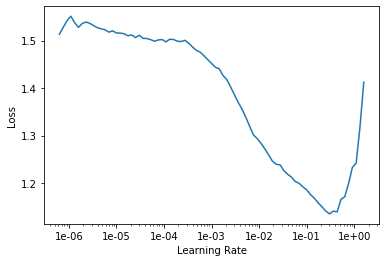

In [269]:
learn_c.recorder.plot()

In [270]:
lr = 2e-1
lr *= bs/48

wd = 0.1

In [271]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.782363,0.740862,0.811891,0.810821,00:05
1,0.669151,0.603263,0.886940,0.885194,00:05


In [272]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [273]:
learn_c.fit_one_cycle(2, lr, wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.804053,0.826902,0.799220,0.797032,00:05
1,0.686486,0.600855,0.872320,0.870989,00:05


In [274]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [275]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.685813,8.436700,0.276803,0.129865,00:06
1,0.555300,0.481057,0.938596,0.937657,00:06


In [276]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [277]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.700830,0.595482,0.893762,0.896527,00:08
1,0.561451,0.488908,0.939571,0.938417,00:07


In [278]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [279]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.539848,0.496198,0.944444,0.943656,00:13
1,0.498390,0.459348,0.956140,0.955176,00:12


In [280]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [281]:
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.507406,0.468136,0.952242,0.951306,00:13
1,0.469209,0.446688,0.961014,0.960839,00:12


In [282]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [283]:
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.496826,0.471526,0.951267,0.949989,00:13
1,0.451470,0.441385,0.961014,0.960459,00:13


In [284]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [285]:
learn_c.fit_one_cycle(2, slice(lr/100/(2.6**4),lr/100), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.435016,0.438589,0.961988,0.961355,00:13
1,0.430054,0.435802,0.964912,0.964211,00:13


In [286]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [289]:
learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')
learn_c.fit_one_cycle(1, slice(lr/100/(2.6**4),lr/100), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.422198,0.432582,0.965887,0.965141,00:13


In [290]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [293]:
learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')
learn_c.fit_one_cycle(2, slice(lr/1000/(2.6**4),lr/1000), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.417618,0.436499,0.963938,0.963218,00:13
1,0.414253,0.433474,0.966862,0.966414,00:13


In [294]:
learn_c.save(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd')

In [55]:
learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd');
learn_c.to_fp32().export(f'{lang}_classifier_tcu_jurisp_reduzido_sp15_multifit_bwd')

### Confusion matrix

In [295]:
%%time
data_clas = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)

config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=1.0, 
                                  metrics=[accuracy,f1])
learn_c.load_encoder(f'{lang}fine_tuned_enc_tcu_jurisp_reduzido_sp15_multifit_bwd');

learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd');

# put weight on cpu
loss_weights = torch.FloatTensor(trn_weights).cpu()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

CPU times: user 2.16 s, sys: 256 ms, total: 2.41 s
Wall time: 1.05 s


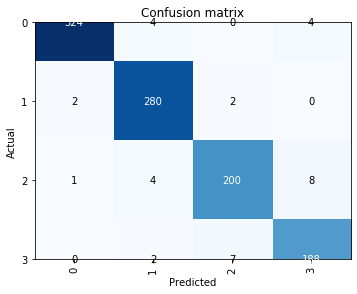

In [296]:
preds,y,losses = learn_c.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

interp = ClassificationInterpretation(learn_c, preds, y, losses)
interp.plot_confusion_matrix()

In [297]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3])/(cm.sum())}')

# acc neg, acc pos
print(f'accuracy on class 0: {cm[0,0]/(cm.sum(1)[0])*100}') 
print(f'accuracy on class 1: {cm[1,1]/(cm.sum(1)[1])*100}')
print(f'accuracy on class 2: {cm[2,2]/(cm.sum(1)[2])*100}')
print(f'accuracy on class 3: {cm[3,3]/(cm.sum(1)[3])*100}')

[[324   4   0   4]
 [  2 280   2   0]
 [  1   4 200   8]
 [  0   2   7 188]]
accuracy global: 0.9668615984405458
accuracy on class 0: 97.59036144578313
accuracy on class 1: 98.59154929577466
accuracy on class 2: 93.89671361502347
accuracy on class 3: 95.43147208121827


In [298]:
learn_c.show_results()

text,target,prediction
". ▁ ) ▁1993 ▁/ ▁8.666 ▁lei ▁xxmaj ▁da o ▁3 . art ▁( ” ▁administração ▁xxmaj ▁a ▁para ▁vantajosa mais ▁ ▁proposta ▁a r na io ec l se “ ▁ ▁a ▁modo ▁de , ▁interessados ▁eventuais ▁os ▁entre ” ▁isonomia ▁da ▁constitucional ▁princípio ▁do observância ▁ ▁a ir nt ra ga “ ▁ ▁necessariamente rá ▁deve ▁administração ▁xxmaj ▁a , ▁questão ▁em ▁advocatícios ▁serviços ▁dos ▁contratação ▁na ▁adotada",1,1
"▁2002. ▁/ 20 ▁10.5 ▁lei ▁xxmaj ▁da o ▁9 . ▁art ▁do ▁força ▁por ▁pregão ▁xxmaj ▁ao subsidiariamente ▁ ▁aplicável , ▁1993 ▁/ ▁8.666 ▁lei ▁xxmaj ▁da , o ▁2 ▁§ , 45 ▁ . ▁art ▁no ▁disposto ▁o ▁observado , ▁público ▁interesse ▁ao á ▁atender ▁que ▁oferta ▁da io te r o s ▁ ▁ao ▁proceder ▁1991, ▁/ 8 ▁8.24 ▁lei ▁xxmaj ▁da o ▁3 . ▁art ▁do ▁atualizada",1,1
". ▁pensão ▁de ▁benefício ▁do ▁econômica ▁dependência ▁a e ▁descaracteriz ▁que ▁renda r ▁auferi ) ▁c ▁ou ; ▁ocupação ▁dessa ▁decorrente ▁aposentadoria ▁receber ▁ou , ▁indireta ▁xxmaj ▁ou ▁direta ▁xxmaj ▁pública ▁xxmaj ▁administração ▁xxmaj ▁na ▁efetivo ▁cargo ▁ocupar ) ▁b ; ▁estável ▁união ▁de ▁situação ▁na r ▁encontra ▁se ▁ou ▁casamento do í ▁contra ▁ter ) ▁a : ▁benefício ▁do ▁percepção ▁à ▁direito ▁do s tiva n ti ▁ex s",0,0
". ▁escolhida ▁opção ▁a ▁para ▁motivação ▁adequada ▁a ▁observar ▁devendo , ▁1998 ▁/ 6 3 ▁9.6 ▁lei ▁xxmaj ▁da , o ▁2 ▁§ , ▁30 . ▁art ▁do ▁e ▁1993 ▁/ ▁8.666 ▁lei ▁xxmaj ▁da , ▁i ▁xxup ▁inciso , ▁17 . ▁art ▁do ▁termos ▁nos , ▁licitatório ▁procedimento ▁o ▁realizar ▁ou , ▁1993 ▁/ ▁8.666 ▁lei ▁xxmaj ▁da , ▁x ▁xxup ▁inciso ▁24, . ▁art ▁do s ▁constante ▁requisitos",1,1
". ▁plenário ▁xxmaj - ▁ ▁1999 ▁/ 5 ▁92 ▁decisão ▁xxmaj ▁da 2 . 1 ▁8. m ▁subite ▁do ▁termos ▁nos , ▁vpni ▁xxup ▁em ▁transformada ▁incorporação adeira r r ▁de ▁essa , ▁também , ▁ficando , ▁meses doze ▁ ▁de ▁interstício ▁o ▁completado ▁for ▁que ▁em ▁específica ▁data ▁na ▁quintos ▁de ▁parcela ▁uma mais ▁ ▁de ▁ou ▁primeira ▁da ▁concessão ▁para , ▁incorporação quer ▁qual ▁em ▁empregado ▁não ▁que",0,0


### Predictions some random sentences

In [299]:
import matplotlib.cm as cm

In [300]:
# Get the prediction neg/pos
review = 'é permitida a utilização do chamamento público para permuta de imóveis'
pred = learn_c.predict(review)
print(pred[0], pred[2])

1 tensor([-0.8959,  2.1027, -0.6058, -0.3864])


In [301]:
# The darker the word-shading in the below example, the more it contributes to the classification. 
txt_ci = TextClassificationInterpretation.from_learner(learn_c)
test_text = "é permitida a utilização do chamamento público para permuta de imóveis"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [302]:
txt_ci.intrinsic_attention(test_text)[1]

tensor([1.0000, 0.0524, 0.0671, 0.0523, 0.1256, 0.1826, 0.0780, 0.1662, 0.0208,
        0.0405, 0.0149, 0.0134], device='cuda:0')

In [303]:
# tabulation showing the first k texts in top_losses along with their prediction, actual,loss, and probability of actual class.
# max_len is the maximum number of tokens displayed. If max_len=None, it will display all tokens.
txt_ci.show_top_losses(5)

Text,Prediction,Actual,Loss,Probability
"▁xxbos ▁xxmaj ▁carece ▁de ▁respald o ▁legal ▁a ▁contagem ▁em ▁dobro , ▁para ▁fins ▁de ▁aposentadoria ▁de ▁magistrado , ▁de ▁licença - prêmio ▁referente ▁a ▁período ▁implementado ▁a pós ▁a ▁data ▁de ▁14 ▁/ ▁03 ▁/ ▁1979. ▁xxmaj ▁relativa mente ▁à ▁aposentadoria ▁no ▁cargo ▁de ▁xxmaj ▁desembargador , ▁aplica - se ▁a ▁vantagem ▁do ▁art . ▁184 ▁da ▁xxmaj ▁lei ▁1.711 ▁/ ▁1952 , ▁com b in ado ▁com ▁o",1,0,2.96,0.16
"▁xxbos ▁xxmaj ▁as ▁licitações ▁com ▁recursos ▁oriundos ▁de ▁empréstimo ▁do ▁xxmaj ▁banco ▁xxmaj ▁mund ial ▁devem ▁contempla r ▁as ▁prescri ções ▁dos ▁art . ▁7 o , ▁§ ▁2 o , ▁inciso ▁xxup ▁ii , ▁e ▁40, ▁§ ▁2 o , ▁inciso ▁xxup ▁ii , ▁da ▁xxmaj ▁lei ▁8.666 ▁/ ▁1993 , ▁de ▁modo ▁que ▁seja ▁conhecido ▁pelos ▁possíveis ▁interessados ▁na ▁licitação ▁o ▁orçamento ▁estimado ▁em ▁planilhas ▁de ▁quantitativos ▁e",1,1,2.72,3.02
"▁xxbos ▁é ▁vedada ▁a ▁contratação ▁da ▁xxmaj ▁empresa ▁xxmaj ▁brasileira ▁de ▁xxmaj ▁correios ▁e ▁xxmaj ▁ tel é g ra f os ▁xxup ▁( ec t ) ▁para ▁ prestação ▁de ▁serviços ▁de ▁ lo g ística , ▁mediante ▁dispensa ▁de ▁licitação ▁com ▁fundamento ▁no ▁art . ▁24, ▁inciso ▁xxup ▁viii , ▁da ▁xxmaj ▁lei ▁8.666 ▁/ ▁1993.",0,1,2.41,-0.81
"▁xxbos ▁a ▁comprovação ▁da ▁assiduidade ▁de ▁servidor ▁do ▁xxmaj ▁tribunal ▁de ▁xxmaj ▁contas ▁da ▁xxmaj ▁união ▁se ▁faz ▁por ▁meio ▁de ▁registro s ▁em ▁equipamento ▁eletrônico ▁e ▁sistema ▁informa ti z ado ▁específicos ▁e , ▁na ▁sua ▁ausência , ▁por ▁elementos ▁objetivos . ▁xxmaj ▁no ▁caso ▁de ▁sus p e ita s ▁levantada s ▁pela ▁chefia ▁imediata , ▁cabe ▁ao ▁próprio ▁servidor ▁comprovar ▁sua ▁presença ▁nas ▁dependência s ▁da ▁instituição",3,0,2.37,-1.14
"▁xxbos ▁a ▁eventual ▁adoção ▁de ▁medidas ▁corre tiva s ▁posteriores ▁ao ▁julgamento ▁das ▁contas , ▁em ▁cumprimento ▁às ▁determinações ▁expedida s ▁pelo ▁xxup ▁tcu , ▁não ▁elide ▁as ▁ocorrência s ▁que ▁motiva ram ▁a ▁irregularidade ▁das ▁contas ▁e ▁imposi ção ▁de ▁multa ▁ao ▁responsável .",1,2,2.37,-0.78


## Ensemble

In [309]:
bs = 18

In [310]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [311]:
data_clas = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, config=config, drop_mult=0.3, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit', purge=False);

In [312]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9688), tensor(0.9687))

In [305]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_tcu_jurisp_reduzido_sp15_multifit_bwd', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, config=config, drop_mult=0.3, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_tcu_jurisp_reduzido_sp15_multifit_bwd', purge=False);

In [306]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.9669), tensor(0.9669))

In [313]:
preds_avg = (preds+preds_b)/2

In [314]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.9737), tensor(0.9737))

In [315]:
from sklearn.metrics import confusion_matrix

predictions = np.argmax(preds_avg, axis = 1)
cm = confusion_matrix(np.array(targs_b), np.array(predictions))
print(cm)

## acc
print(f'accuracy global: {(cm[0,0]+cm[1,1]+cm[2,2]+cm[3,3])/(cm.sum())}')

# acc neg, acc pos
print(f'accuracy on class 0: {cm[0,0]/(cm.sum(1)[0])*100}') 
print(f'accuracy on class 1: {cm[1,1]/(cm.sum(1)[1])*100}')
print(f'accuracy on class 2: {cm[2,2]/(cm.sum(1)[2])*100}')
print(f'accuracy on class 3: {cm[3,3]/(cm.sum(1)[3])*100}')

[[326   4   0   2]
 [  2 281   1   0]
 [  0   2 206   5]
 [  1   3   7 186]]
accuracy global: 0.9736842105263158
accuracy on class 0: 98.19277108433735
accuracy on class 1: 98.94366197183099
accuracy on class 2: 96.71361502347418
accuracy on class 3: 94.41624365482234
